In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from matplotlib.colors import LogNorm, Normalize
import matplotlib.cm as cm

import torch
import torch.optim as optim
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits

import h5py

sys.path.append(os.getcwd())
torch.manual_seed(32)
np.random.seed(32)

In [2]:
ATLAS_raw_dir = '/fast_scratch_1/caloqvae/data/atlas_test/dataset_eta_020_positive.hdf5'

In [ ]:
class PLT_ATLAS:
    def __init__(self, raw_dir, event_n, all_layers=None):
        """
        Initialize the PLT_ATLAS object.

        Parameters:
        - raw_dir: Path to the raw HDF5 data file.
        - event_n: Event number to process.
        - all_layers: List of layer numbers to plot. Defaults to [0, 1, 2, 3, 12].
        """
        if all_layers is None:
            all_layers = [0, 1, 2, 3, 12]
        self.ATLAS_raw_dir = raw_dir
        self.data = h5py.File(self.ATLAS_raw_dir, 'r')
        self.event_n = event_n
        self.all_layers = all_layers

    def get_section_info(self):
        """
        Process and retrieve sector information for plotting.

        Returns:
        - List of tuples containing (inner_r, outer_r, start_angle, end_angle, energy).
        """
        # Convert angles from radians to degrees and round
        binstart_alpha_deg = torch.round(self.binstart_alpha_info / torch.pi * 180)
        binend_alpha_deg = binstart_alpha_deg + torch.round(self.binsize_alpha_info / torch.pi * 180)
        
        # Calculate end radius
        binend_radius_info = self.binstart_radius_info + self.binsize_radius_info
        
        # Combine all sector information into a list of tuples
        sectors = list(zip(
            self.binstart_radius_info.tolist(),
            binend_radius_info.tolist(),
            binstart_alpha_deg.tolist(),
            binend_alpha_deg.tolist(),
            self.single_event_energy.tolist()
        ))
        return sectors

    def plot_calorimeter(self, ax, scale='equal_bin', cmap=cm.viridis, norm=None, title=None):
        """
        Plot the Calorimeter Layer Energy Diagram on a given axis.

        Parameters:
        - ax: Matplotlib axis to plot on.
        - scale: 'linear' or 'equal_bin', determines the type of radial scale.
        - cmap: Colormap for the energy representation.
        - norm: Normalization for the colormap.
        - title: Title for the subplot.
        """
        sectors = self.sectors

        # If normalization is not provided, create it based on current energies
        if norm is None:
            energies = [sector[4] for sector in sectors]
            norm = LogNorm(vmin=max(min(values), 0.0001), vmax=max(max(values), 0.0001))

        if scale == 'linear':
            # Linear radial scale
            max_radius = max(sector[1] for sector in sectors)
            transform = lambda r: r
        elif scale == 'equal_bin':
            # Equal bin radial scale
            radial_boundaries = sorted({r for sector in sectors for r in (sector[0], sector[1])})
            num_layers = len(radial_boundaries) - 1
            plot_radial_boundaries = np.linspace(0, 1, num_layers + 1)

            def transform(r):
                """
                Map actual radius to plot radius ensuring equal space for each layer.
                """
                for i in range(num_layers):
                    if radial_boundaries[i] <= r < radial_boundaries[i + 1]:
                        layer_fraction = (r - radial_boundaries[i]) / (radial_boundaries[i + 1] - radial_boundaries[i])
                        return plot_radial_boundaries[i] + layer_fraction * (plot_radial_boundaries[i + 1] - plot_radial_boundaries[i])
                return plot_radial_boundaries[-1]  # Handle the maximum boundary

            max_radius = plot_radial_boundaries[-1]
        else:
            raise ValueError("The 'scale' parameter must be 'linear' or 'equal_bin'")

        # Plot each sector as a wedge
        for inner_r, outer_r, start_angle, end_angle, energy in sectors:
            color = cmap(norm(energy))
            if scale == 'equal_bin':
                transformed_inner = transform(inner_r)
                transformed_outer = transform(outer_r)
                width = transformed_outer - transformed_inner
                wedge = Wedge(
                    center=(0, 0),
                    r=transformed_outer,
                    theta1=start_angle,
                    theta2=end_angle,
                    width=width,
                    edgecolor='black',
                    facecolor=color,
                    alpha=1
                )
            else:  # 'linear'
                wedge = Wedge(
                    center=(0, 0),
                    r=transform(outer_r),
                    theta1=start_angle,
                    theta2=end_angle,
                    width=transform(outer_r) - transform(inner_r),
                    edgecolor='black',
                    facecolor=color,
                    alpha=1
                )
            ax.add_patch(wedge)

        # Configure plot limits and appearance
        ax.set_xlim(-max_radius - 0.1, max_radius + 0.1)
        ax.set_ylim(-max_radius - 0.1, max_radius + 0.1)
        ax.set_aspect('equal')
        ax.axis('off')

        # Add title if provided
        if title:
            ax.set_title(title, fontsize=25)

    def plot_all_layers(self, scale='equal_bin', vmin=1e-2, vmax=1e4):
        """
        Plot all specified layers of the calorimeter for the given event in a composite figure.

        Parameters:
        - scale: 'linear' or 'equal_bin', determines the type of radial scale for all subplots.
        """
        num_layers = len(self.all_layers)
        # Create a figure with subplots arranged in one row
        fig, axes = plt.subplots(1, num_layers, figsize=(6 * num_layers, 7), constrained_layout=True)
        
        # Ensure axes is iterable
        if num_layers == 1:
            axes = [axes]

        # Initialize variables to determine global normalization across all layers
        all_energies = []

        # First pass: Collect all energies to set a common normalization

        # Define global normalization
        norm = LogNorm(vmin=vmin, vmax=vmax)
        incident_energy = torch.tensor(self.data["incident_energy"][self.event_n])
        # Iterate through each layer and plot on the corresponding axis
        for ax, layer in zip(axes, self.all_layers):
            # Retrieve and process data for the current layer
            energy_info = torch.tensor(self.data[f'energy_layer_{layer}'][self.event_n, :])
            binsize_alpha = torch.tensor(self.data[f"binsize_alpha_layer_{layer}"][:])
            binstart_alpha = torch.tensor(self.data[f"binstart_alpha_layer_{layer}"][:])
            binsize_radius = torch.tensor(self.data[f"binsize_radius_layer_{layer}"][:])
            binstart_radius = torch.tensor(self.data[f"binstart_radius_layer_{layer}"][:])
            single_event_energy = energy_info * incident_energy

            # Assign data to instance variables for section info retrieval
            self.binsize_alpha_info = binsize_alpha
            self.binstart_alpha_info = binstart_alpha
            self.binsize_radius_info = binsize_radius
            self.binstart_radius_info = binstart_radius
            self.single_event_energy = single_event_energy

            # Get sector information
            self.sectors = self.get_section_info()

            # Plot on the provided axis with a common normalization
            self.plot_calorimeter(ax=ax, scale=scale, norm=norm, title=f'Layer {layer}')

        # Add a single colorbar for all subplots
        # Positioning the colorbar to the right of all subplots
        fig.suptitle(f'Calorimeter Layer Energy Diagram when E = {incident_energy/1000:.2f} GeV\n', fontsize=30)
        cbar_ax = fig.add_axes([0.05, -0.1, 0.9, 0.1])  # [left, bottom, width, height]
        cmap = cm.viridis
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, cax=cbar_ax, location='bottom', orientation='horizontal')
        cbar.set_label('Energy in MeV', fontsize=25)
        cbar.ax.tick_params(labelsize=20)  # 设置刻度标签字体大小为12

        plt.show()

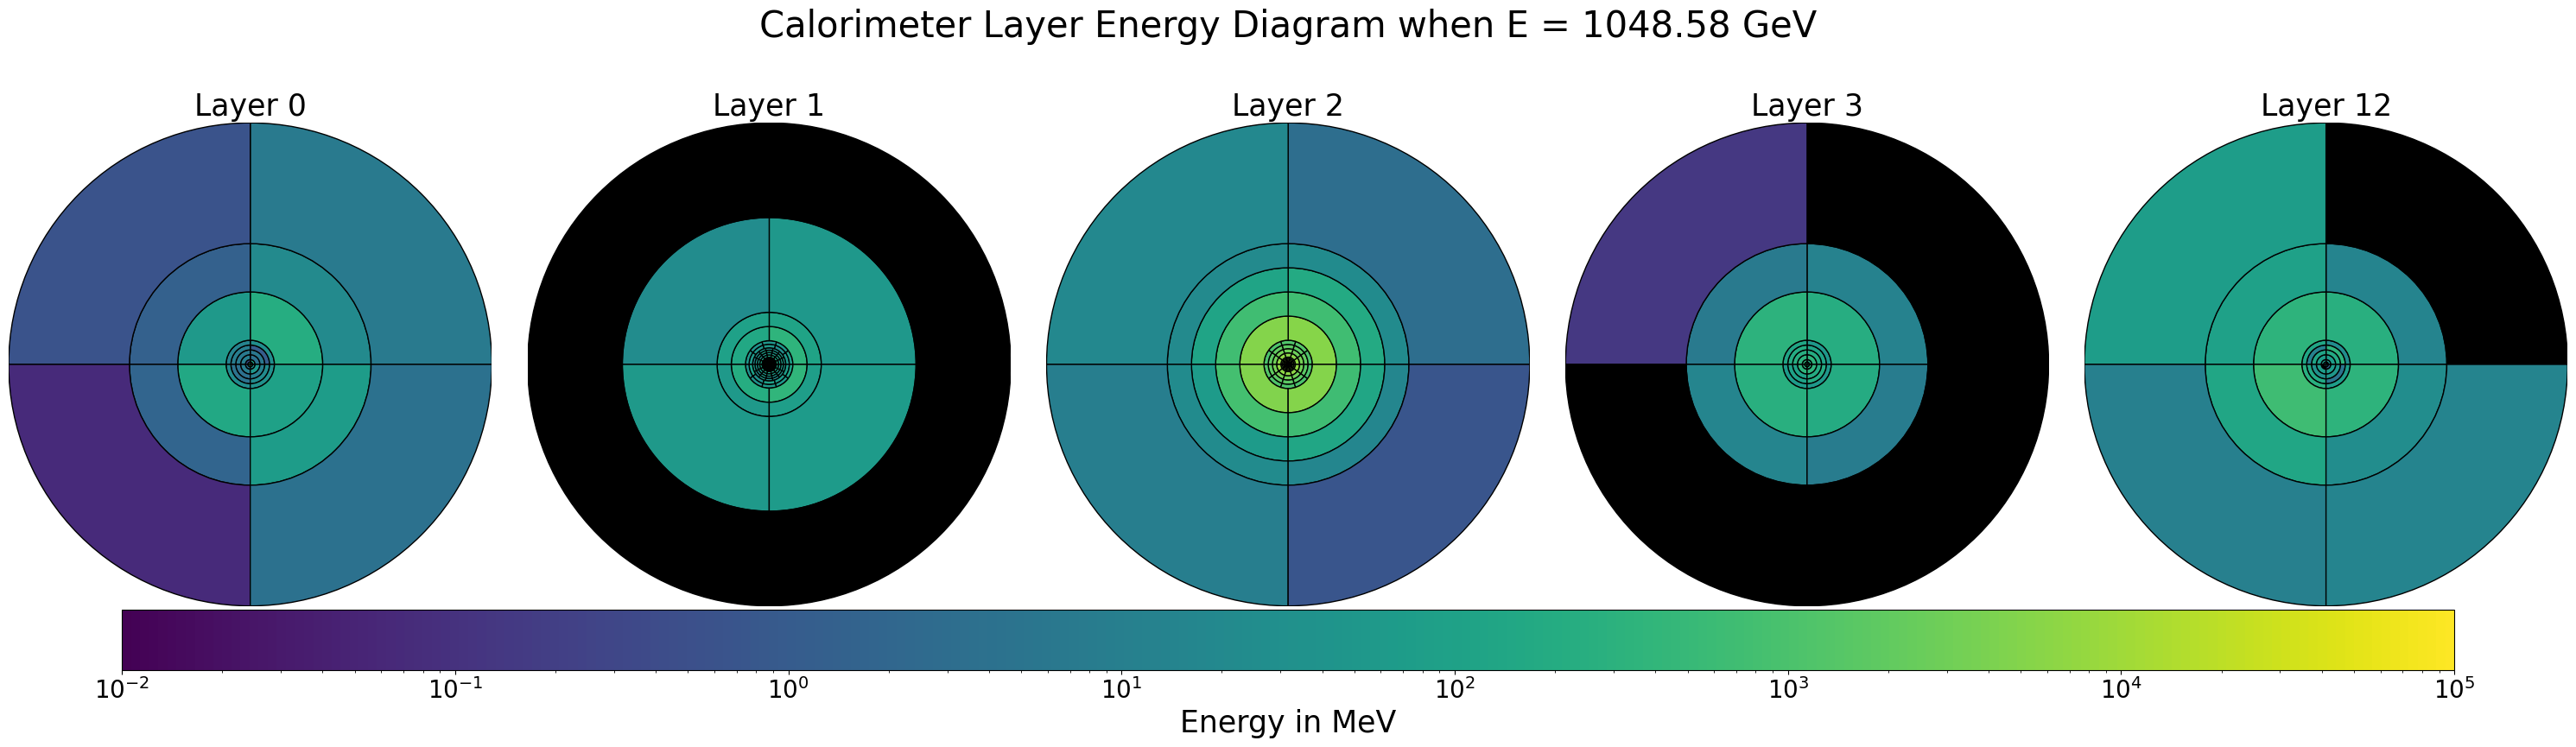

In [5]:
plot_atlas = PLT_ATLAS(ATLAS_raw_dir,117270).plot_all_layers(scale='linear',vmin=1e-2, vmax=1e5)

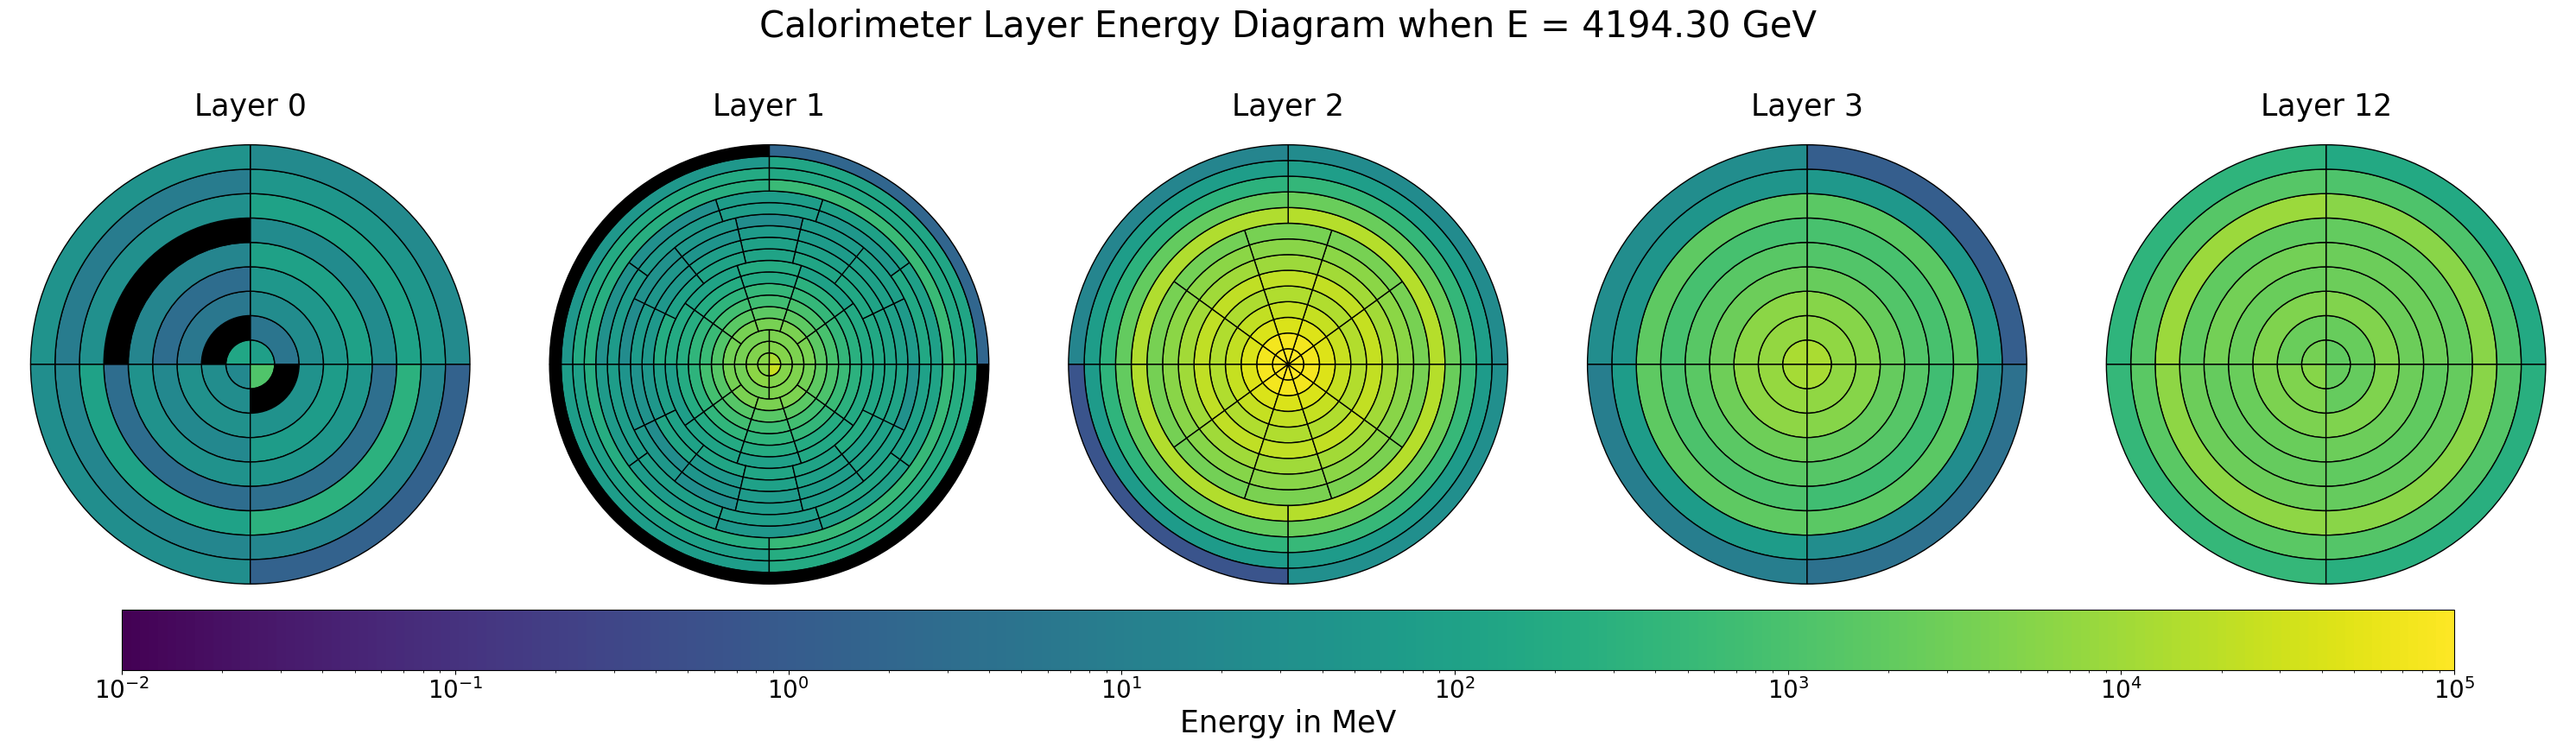

In [37]:
plot_atlas = PLT_ATLAS(ATLAS_raw_dir,125000)
plot_atlas.plot_all_layers(scale='equal_bin',vmin=1e-2, vmax=1e5)

In [26]:
print('Bin Start Alpha:\n', [round(x, 2) for x in aaa.binstart_alpha_info.tolist()])
print('Bin Size Alpha:\n', [round(x, 2) for x in aaa.binsize_alpha_info.tolist()])
print('Bin Size Radius:\n', [round(x, 2) for x in aaa.binsize_radius_info.tolist()])
print('Bin Start Radius:\n', [round(x, 2) for x in aaa.binstart_radius_info.tolist()])

Bin Start Alpha:
 [0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71, 0.0, 1.57, 3.14, 4.71]
Bin Size Alpha:
 [1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57]
Bin Size Radius:
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 500.0, 500.0, 500.0, 500.0]
Bin Start Radius:
 [0.0, 0.0, 0.0, 0.0, 10.0, 10.0, 10.0, 10.0, 20.0, 20.0, 20.0, 20.0, 40.0, 40.0, 40.0, 40.0, 60.0, 60.0, 60.0, 60.0, 80.0, 80.0, 80.0, 80.0, 100.0, 100.0, 100.0, 100.0, 300.0, 300.0, 300.0, 300.0, 500.0, 500.0, 500.0, 500.0]
